
# Setting Google drive

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"majdalotaibi","key":"8b788d2d31ab0efc12b7bbc5bf75bf5b"}'}

In [2]:
!pip install -U opendatasets -q
import opendatasets
opendatasets.download('https://www.kaggle.com/datasets/msambare/fer2013')

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013


# Importing the Libraries

In [4]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.regularizers import l2

# Loading the Dataset & Labeling

In [5]:
# All Folders

# base_path = '/content/fer2013'

# def create_dataframe(split):
#     data = []
#     split_path = os.path.join(base_path, split)

#     for label in os.listdir(split_path):
#         label_path = os.path.join(split_path, label)

#         if os.path.isdir(label_path):
#             for img_file in os.listdir(label_path):
#                 img_path = os.path.join(label_path, img_file)
#                 data.append([img_path, label])

#     return pd.DataFrame(data, columns=['image_path', 'label'])

# train_df = create_dataframe('train')
# test_df = create_dataframe('test')

# just spesfics Folders


base_path = '/content/fer2013'
allowed_labels = {'happy', 'angry', 'neutral'}

def create_dataframe(split):
    data = []
    split_path = os.path.join(base_path, split)

    for label in os.listdir(split_path):
        if label not in allowed_labels:
            continue

        label_path = os.path.join(split_path, label)

        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                data.append([img_path, label])

    return pd.DataFrame(data, columns=['image_path', 'label'])

train_df = create_dataframe('train')
test_df = create_dataframe('test')

# Dataset Exploration

In [7]:
train_df.head()

,image_path,label,split
0,/content/fer2013/train/happy/Training_39766622...,happy,train
1,/content/fer2013/train/happy/Training_11206878...,happy,train
2,/content/fer2013/train/happy/Training_46991180...,happy,train
3,/content/fer2013/train/happy/Training_3887027.jpg,happy,train
4,/content/fer2013/train/happy/Training_12630394...,happy,train


In [8]:
train_df.shape

(16175, 3)

In [9]:
train_df['label'].value_counts()

,count
label,
happy,7215
neutral,4965
angry,3995


In [10]:
import pandas as pd

min_count = train_df['label'].value_counts().min()

train_df = (
    train_df
    .groupby('label')
    .apply(lambda x: x.sample(n=min_count, random_state=42))
    .reset_index(drop=True)
)


train_df['label'].value_counts()

<ipython-input-10-e7159fe61b30>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_count, random_state=42))


,count
label,
angry,3995
happy,3995
neutral,3995


In [11]:
test_df.shape

(3965, 3)

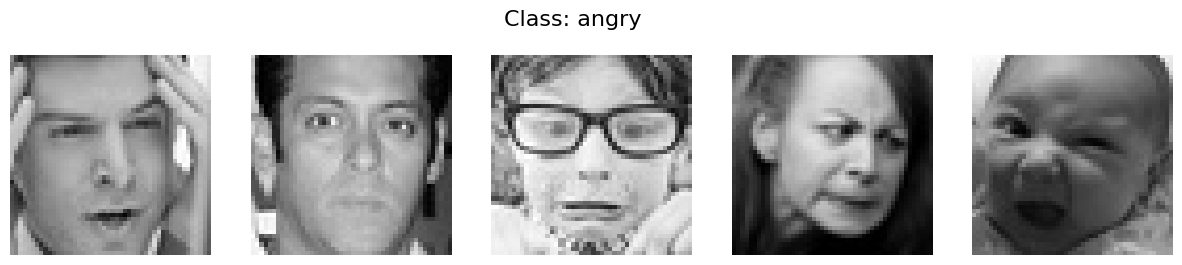

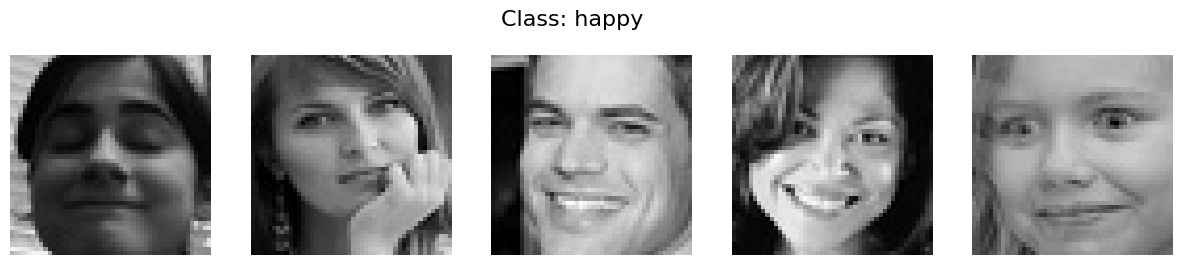

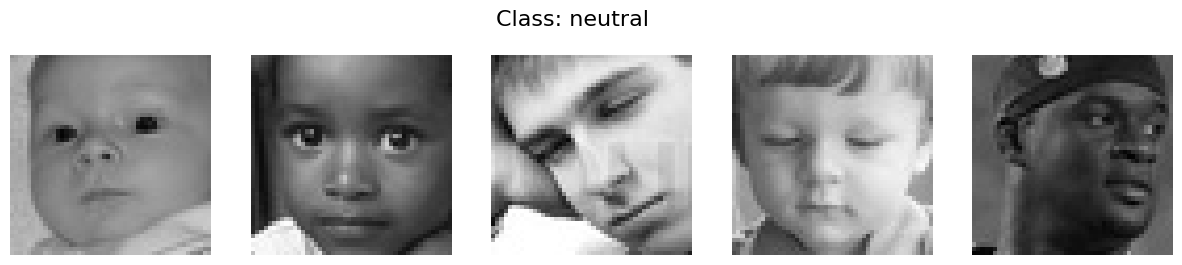

In [12]:
classes = train_df['label'].unique()

for label in classes:
    subset = train_df[train_df['label'] == label].head(5)

    plt.figure(figsize=(15, 3))
    plt.suptitle(f'Class: {label}', fontsize=16)

    for i, row in enumerate(subset.itertuples(), 1):
        img = cv2.imread(row.image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 5, i)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

# Data Splitting

In [13]:
new_train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['label'],
    random_state=42
)

print("New train shape:", new_train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

New train shape: (9588, 3)
Validation shape: (2397, 3)
Test shape: (3965, 3)


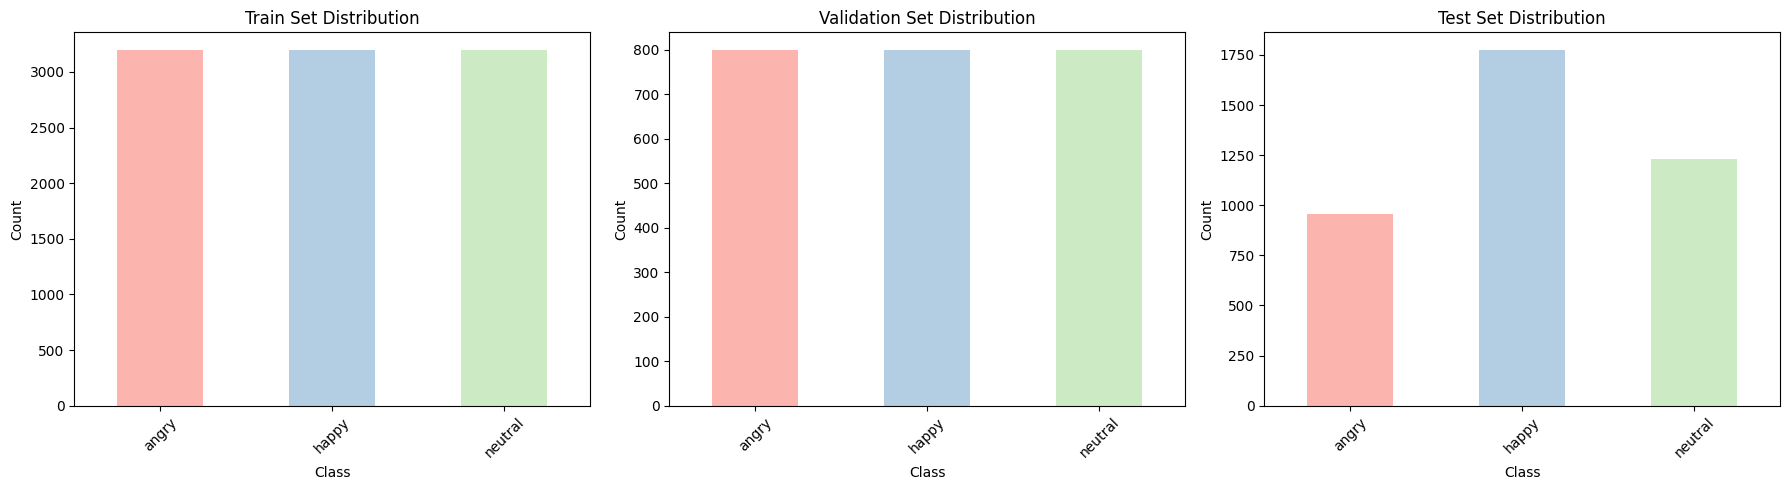

In [14]:
distributions = {
    'Train Set': new_train_df['label'].value_counts().sort_index(),
    'Validation Set': val_df['label'].value_counts().sort_index(),
    'Test Set': test_df['label'].value_counts().sort_index()
}

labels = sorted(set().union(*[dist.index for dist in distributions.values()]))

colors = list(plt.cm.Pastel1.colors)

plt.figure(figsize=(18, 5))
for i, (title, dist) in enumerate(distributions.items(), 1):
    plt.subplot(1, 3, i)
    dist = dist.reindex(labels, fill_value=0)
    dist.plot(kind='bar', color=colors[:len(labels)])
    plt.title(f'{title} Distribution')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.xlabel('Class')

plt.tight_layout()
plt.show()


# Data Augmentation

In [72]:
WIDTH, HEIGHT = 48, 48
batch_size = 64

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     # zoom_range=0.1,
#     # horizontal_flip=True
# )
train_generator = train_datagen.flow_from_dataframe(
    dataframe=new_train_df,
    x_col='image_path',
    y_col='label',
    target_size=(WIDTH, HEIGHT),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(WIDTH, HEIGHT),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    # shuffle=False
    shuffle=True
)


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(WIDTH, HEIGHT),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 9588 validated image filenames belonging to 3 classes.
Found 2397 validated image filenames belonging to 3 classes.
Found 3965 validated image filenames belonging to 3 classes.


In [16]:
train_generator.class_indices

{'angry': 0, 'happy': 1, 'neutral': 2}

# Building the CNN Model

In [ ]:
import gc
import tensorflow as tf
tf.keras.backend.clear_session()
gc.collect()


0

In [ ]:
model = Sequential([
    Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    # Conv2D(64, kernel_size=(3, 3), activation='relu'),
    # Conv2D(256, kernel_size=(3, 3), activation='relu'),
    # MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    #2
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    # Dense(16, activation='relu'),
    #2
    Dropout(0.5),
    Dense(4, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## EXP 2

In [82]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    # Conv2D(32, kernel_size=(3, 3), activation='relu'),
    # BatchNormalization(),
    # MaxPooling2D(pool_size=(2, 2)),

    # Conv2D(32, kernel_size=(3, 3), activation='relu'),
    # BatchNormalization(),
    # MaxPooling2D(pool_size=(2, 2)),
    # Dropout(0.5),

# 16,32,64 = 57 K

    Conv2D(16, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),



    Flatten(),
#
    # Dense(128, activation='relu'),
    # BatchNormalization(),
    # Dense(64, activation='relu'),
    # BatchNormalization(),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(10, activation='relu'),
    Dense(3, activation='softmax')
])

## EXP 3

In [88]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(3, activation='softmax')
])


In [89]:
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,059 (1.39 MB)

 Trainable params: 364,227 (1.39 MB)

 Non-trainable params: 832 (3.25 KB)

# Compiling the Model

In [90]:
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import Nadam
model.compile(
    loss='categorical_crossentropy',
    # optimizer=Adam(lr=0.0001, decay=1e-6),
    # optimizer=Adam(learning_rate=0.01),
    # optimizer=AdamW(learning_rate=0.001, weight_decay=1e-4),
    # optimizer=AdamW(),
    # optimizer='rmsprop',
    # optimizer=SGD(),
    # optimizer=Adagrad(learning_rate=0.01),
    optimizer=Nadam(learning_rate=0.0005),

    # optimizer = RMSprop(learning_rate=0.001),
    metrics=['accuracy']
)

# Training the Model

In [85]:
from keras.callbacks import Callback

class StopTrainingOnValidationAccuracy(Callback):
    def __init__(self, target_accuracy):
        super(StopTrainingOnValidationAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs.get('val_accuracy')
        if current_val_accuracy is not None and current_val_accuracy >= self.target_accuracy:
            print(f"Reached target validation accuracy ({self.target_accuracy}), stopping training!")
            self.model.stop_training = True


target_val_accuracy = 0.91
stop_callback = StopTrainingOnValidationAccuracy(target_val_accuracy)

In [65]:
import gc
gc.collect()

5039

In [91]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=3,
    # min_lr=1e-6,
    # verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[stop_callback,reduce_lr,early_stopping]
)


Epoch 1/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 0.3462 - loss: 2.0050 - val_accuracy: 0.3333 - val_loss: 1.9223 - learning_rate: 5.0000e-04
Epoch 2/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.3703 - loss: 1.7173 - val_accuracy: 0.3333 - val_loss: 1.8935 - learning_rate: 5.0000e-04
Epoch 3/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.3837 - loss: 1.6302 - val_accuracy: 0.3392 - val_loss: 1.8923 - learning_rate: 5.0000e-04
Epoch 4/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.4016 - loss: 1.5731 - val_accuracy: 0.4606 - val_loss: 1.5378 - learning_rate: 5.0000e-04
Epoch 5/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.4208 - loss: 1.5151 - val_accuracy: 0.5123 - val_loss: 1.4330 - learning_rate: 5.0000e-04
Epoch 6/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.4254 - loss: 1.4924 - val_accuracy: 0.5386 - val_loss: 1.3790 - learning_rate: 5.0000e-04
Epoch 7/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/st

In [94]:
model.save('modal80-73.h5')

In [92]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8240 - loss: 0.5812
Test Loss: 0.6264
Test Accuracy: 0.7952


In [93]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = test_generator.classes

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred))

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.65      0.78      0.71       958
           1       0.92      0.84      0.88      1774
           2       0.76      0.75      0.76      1233

    accuracy                           0.80      3965
   macro avg       0.78      0.79      0.78      3965
weighted avg       0.81      0.80      0.80      3965



<Figure size 600x500 with 0 Axes>

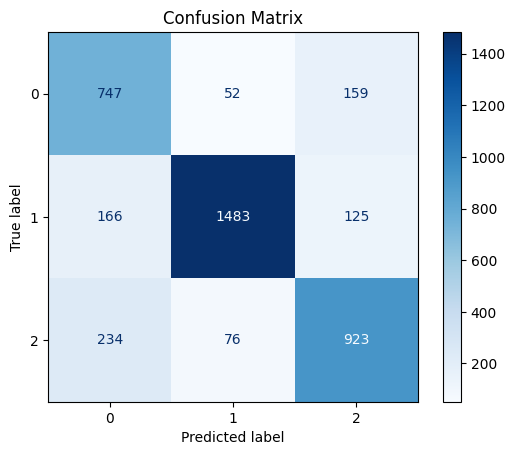

In [95]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [96]:
cm

array([[ 747,   52,  159],
       [ 166, 1483,  125],
       [ 234,   76,  923]])

# EXP 4

In [97]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=AdamW(learning_rate=0.0005, weight_decay=1e-4),
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=3,
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.3542 - loss: 2.0639 - val_accuracy: 0.3333 - val_loss: 1.8675 - learning_rate: 5.0000e-04
Epoch 2/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.3712 - loss: 1.7396 - val_accuracy: 0.3367 - val_loss: 1.7407 - learning_rate: 5.0000e-04
Epoch 3/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.3760 - loss: 1.6571 - val_accuracy: 0.3579 - val_loss: 1.6263 - learning_rate: 5.0000e-04
Epoch 4/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.4099 - loss: 1.5726 - val_accuracy: 0.4305 - val_loss: 1.5115 - learning_rate: 5.0000e-04
Epoch 5/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.4010 - loss: 1.5439 - val_accuracy: 0.4952 - val_loss: 1.4240 - learning_rate: 5.0000e-04
Epoch 6/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.4370 - loss: 1.5023 - val_accuracy: 0.5127 - val_loss: 1.4025 - learning_rate: 5.0000e-04
Epoch 7/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accurac

In [99]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8585 - loss: 0.4897
Test Loss: 0.5588
Test Accuracy: 0.8207


In [100]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = test_generator.classes

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred))

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.75      0.75       958
           1       0.92      0.87      0.89      1774
           2       0.76      0.81      0.78      1233

    accuracy                           0.82      3965
   macro avg       0.81      0.81      0.81      3965
weighted avg       0.82      0.82      0.82      3965



In [101]:
model.save('modal82-74.h5')